## Import dependencies 

In [338]:
%run ../initEnviroment.py
from plot_data import PlotActivity
from matplotlib.lines import Line2D
from scipy.stats import norm, kurtosis
import os
from scipy.signal import butter, lfilter, freqz
from scipy import signal
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from collections import Counter
import joblib

##  Read Data

In [339]:
def read_test_data(experiment):
    
    if experiment < 10:
        experiment = '0' + str(experiment)
    else:
        experiment = str(experiment)

    for j in os.listdir('../data/RawData/'):

        if "acc_exp" + experiment in j:
            
            acc_path = "../data/RawData/" + j

        elif "gyro_exp" + experiment in j:
            
            gyro_path = "../data/RawData/" + j
            
    acc_df = pd.read_csv(acc_path, sep = " ", names=['acc_x','acc_y','acc_z'])
    gyro_df = pd.read_csv(gyro_path, sep = " ", names=['gyro_x','gyro_y','gyro_z'])

    exp_df = pd.concat([acc_df,gyro_df],1)
    exp_df["experiment"] = int(experiment) #keep track of the experiment

        
    return exp_df

In [340]:
def read_real_data():
    
    acc_df = pd.read_csv("../data/RealData/Accelerometer.csv", sep = ",", 
                         names=['time','acc_x','acc_y','acc_z'],header=None)
    acc_df.drop('time',axis = 1, inplace = True)
    acc_df.drop(0,inplace=True)
    
    
    gyro_df = pd.read_csv("../data/RealData/Gyroscope.csv", sep = ",", 
                          names=['time','gyro_x','gyro_y','gyro_z'], header = None) 
    gyro_df.drop('time',axis = 1, inplace = True)
    gyro_df.drop(0,inplace=True)
    
    df = pd.concat([acc_df,gyro_df],1)
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)
    df = df.astype("float")
    
    return df

In [341]:
df = read_test_data(1)

In [374]:
df

,sample,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z,flag,block
0,0,0.252215,-0.030907,0.140034,-0.000734,-0.000930,-0.000412,1,1
1,1,0.773305,-0.089654,0.438044,-0.002846,-0.003136,-0.002017,0,1
2,2,1.008541,-0.106962,0.584635,-0.005557,-0.001238,-0.004389,0,1
3,3,0.918022,-0.088943,0.538670,-0.009205,0.012713,-0.006144,0,1
4,4,0.861996,-0.086538,0.501218,-0.015742,0.041700,-0.007233,0,1
...,...,...,...,...,...,...,...,...,...
20593,20593,-0.067661,0.523451,0.730587,0.014216,0.186316,0.035215,0,81
20594,20594,-0.067433,0.530342,0.832310,-0.010773,0.208203,0.014004,0,81
20595,20595,-0.060065,0.522226,0.925009,-0.065671,0.190563,0.002037,0,81
20596,20596,-0.054601,0.517769,0.965794,-0.132528,0.143767,-0.001228,0,81


In [342]:
#df =  read_real_data()

## Filter data

In [343]:
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

def filter_acc(df, cutoff=10, fs=50, order=2):
    
    signals = ["acc_x","acc_y","acc_z"]
    
    new_df = pd.DataFrame(columns=signals)

    list_signals = []

    for j in signals:

        filtered_signal = butter_lowpass_filter(df[j], cutoff=cutoff, fs=fs, order=order)

        list_signals.append(filtered_signal)

    new_df = pd.concat([new_df, pd.DataFrame(np.array(list_signals).T,columns=signals)])

    return new_df


def filter_gyro(df, cutoff=10, fs=50, order=2):
    
    signals = ["gyro_x","gyro_y","gyro_z"]
    
    new_df = pd.DataFrame(columns=signals)
    
    list_signals = []

    for j in signals:

        filtered_signal = butter_lowpass_filter(df[j], cutoff=cutoff, fs=fs, order=order)

        list_signals.append(filtered_signal)

    new_df = pd.concat([new_df, pd.DataFrame(np.array(list_signals).T,columns=signals)])
        
    return new_df

In [344]:
def remake_df(df):
    
    filtered_df_acc = filter_acc(df,cutoff = 12)
    filtered_df_gyro = filter_gyro(df,cutoff= 2)


    df = pd.concat([filtered_df_acc.reset_index(drop=True), filtered_df_gyro.reset_index(drop=True)], axis=1)
    df.reset_index(inplace = True)
    
    df.rename(columns={'index': 'sample'},inplace=True)
    
    return df

In [345]:
df = remake_df(df)

## Create clock df

In [346]:
def create_block_df(df,window_size):
    
    df['flag'] = np.where(df.index % window_size == 0,1,0)
    df["block"] = df['flag'].cumsum()
    
    return df

In [347]:
df = create_block_df(df, 256)

## Aggregate data for the features

In [348]:
def kurtosis_time(x):

    return kurtosis(x, fisher=True)

def rms_100(x):

    return np.sqrt(np.mean(x**2)) 

def crest(x):
    
    return max(abs(x))/np.sqrt(np.mean(x**2))

In [349]:
def create_aggregated(block_df):
    
    signals = ["acc_x", "acc_y", "acc_z", "gyro_x", "gyro_y", "gyro_z"]
    
    samples = {"sample": ["first",'last']}
    functions = {x: ["sum", "mean", "mad",
                    "median", "min", "max", 
                    "std", "var", "sem", 
                    "skew", "quantile", 
                    kurtosis_time, rms_100, 
                    crest] for x in signals}
    

    samples.update(functions)
    
    agg_df = block_df.groupby("block").agg(samples)
    
    return agg_df

In [350]:
agg_df = create_aggregated(df)

In [351]:
def do_fft(df):
    
    "Creat a new df with the frequency spectrum of each blocks"
    
    signals = ["acc_x","acc_y","acc_z","gyro_x","gyro_y","gyro_z"]
    #df.columns = ['index', 'id', 'experiment', 'activity'] + signals + ["block"]
    
    new_df = pd.DataFrame()
    
    for block in df.block.unique():
        
        fft_df = df[df["block"] == block]
        
        list_signals = []
        
        for j in signals:
            
            freq, amp = signal.welch(fft_df[j], 50, nperseg=64)
            
            list_signals.append(amp)
            
        list_signals.append(np.full(len(freq), block))
        
        new_df = pd.concat([new_df, pd.DataFrame(np.array(list_signals).T,columns=[x+"_FFT" for x in signals]+["block"])])
        new_df.dropna(axis=1,inplace=True)
        
        
    #new_df["freq"] = np.tile(x,len(df.block.unique()))
    new_df["block"] = new_df["block"].astype('int32')
        
    return new_df

In [352]:
# fft_df

In [353]:
fft_df = do_fft(df)

In [354]:
def peak_sum_all(x):
    
    peaks, _ = signal.find_peaks(x, height=0,)
    
    return sum(peaks)

def peak_mean_12(x):
    
    peaks, hight = signal.find_peaks(x, height=0,)
    hight["peak_heights"][::-1].sort()
    
    if len( hight["peak_heights"])>=12:
    
        return np.mean(hight["peak_heights"][:12])

def peak_mean_8(x):
    
    peaks, hight = signal.find_peaks(x, height=0,)
    hight["peak_heights"][::-1].sort()
    
    if len( hight["peak_heights"])>=8:
    
        return np.mean(hight["peak_heights"][:8])

def peak_mean_6(x):
    
    peaks, hight = signal.find_peaks(x, height=0,)
    hight["peak_heights"][::-1].sort()
    
    if len( hight["peak_heights"])>=6:
    
        return np.mean(hight["peak_heights"][:6])

def peak_mean_2(x):
    
    peaks, hight = signal.find_peaks(x, height=0,)
    hight["peak_heights"][::-1].sort()
    
    if len( hight["peak_heights"])>=2:
    
        return np.mean(hight["peak_heights"][:2])


In [355]:
def kurtosis_freq(x):

    return kurtosis(x, fisher=True)

def rms_10(x):
    
    y = x[:int(len(x)*0.1)]
    
    return np.sqrt(np.mean(y*2))
def rms_20(x):
    
    y = x[:int(len(x)*0.20)]
    
    return np.sqrt(np.mean(y**2))

def rms_50(x):
    
    y = x[:int(len(x)*0.50)]
    
    return np.sqrt(np.mean(y**2))

def rms_80(x):
    
    y = x[:int(len(x)*0.80)]
    
    return np.sqrt(np.mean(y**2))

def rms_100(x):

    return np.sqrt(np.mean(x**2)) 

def quad_sum(x):
    
    return np.sum(x**2)

In [356]:
def create_aggregated_freq(fft_df):
    
    signals = ['acc_x_FFT', 'acc_y_FFT', 'acc_z_FFT', 'gyro_x_FFT', 'gyro_y_FFT','gyro_z_FFT']

    fft_agg_df = fft_df.groupby("block").agg({x: ["sum", "mean", "mad",
                                                  "median", "min", "max", 
                                                  "std", "var", "sem", 
                                                  "skew", "quantile",
                                                  peak_sum_all, kurtosis_freq, peak_mean_2,
                                                  peak_mean_6, peak_mean_8, peak_mean_12,
                                                  rms_10, rms_20, rms_50,
                                                  rms_80, rms_100, quad_sum] for x in signals })
    return fft_agg_df

In [357]:
fft_agg_df = create_aggregated_freq(fft_df)

## Create data for classification

In [358]:
def create_clf_data(agg_df,fft_agg_df):
    
    features = agg_df.merge(fft_agg_df,on="block")
    clf_data = features.drop([('sample','first'),('sample','last')],axis=1)
    
    return clf_data

In [359]:
clf_data = create_clf_data(agg_df,fft_agg_df)

In [360]:
def preprocess_data(df):
  
    
    features_to_drop = [('acc_x_FFT', 'peak_mean_6'),
 ('acc_x_FFT', 'peak_mean_8'),
 ('acc_x_FFT', 'peak_mean_12'),
 ('acc_y_FFT', 'peak_mean_6'),
 ('acc_y_FFT', 'peak_mean_8'),
 ('acc_y_FFT', 'peak_mean_12'),
 ('acc_z_FFT', 'peak_mean_6'),
 ('acc_z_FFT', 'peak_mean_8'),
 ('acc_z_FFT', 'peak_mean_12'),
 ('gyro_x_FFT', 'peak_mean_6'),
 ('gyro_x_FFT', 'peak_mean_8'),
 ('gyro_x_FFT', 'peak_mean_12'),
 ('gyro_y_FFT', 'peak_mean_6'),
 ('gyro_y_FFT', 'peak_mean_8'),
 ('gyro_y_FFT', 'peak_mean_12'),
 ('gyro_z_FFT', 'peak_mean_6'),
 ('gyro_z_FFT', 'peak_mean_8'),
 ('gyro_z_FFT', 'peak_mean_12')]
    
    df.drop(features_to_drop,axis=1, inplace = True)
    
    pipe = Pipeline([("imputer", SimpleImputer(fill_value = 0)),
                         ('scaler', StandardScaler())])
    
    clf_data = pd.DataFrame(pipe.fit_transform(df),columns=df.columns) 
   
    return clf_data
    

In [361]:
clf_data = preprocess_data(clf_data)

In [362]:
def load_model(filename):
    
    # load the model from disk
    model = joblib.load(filename)
    return model

In [363]:
model = load_model("../models/har_model_v06.sav")

In [364]:
def classify(df,model):
    
    labels = model.predict(df)
    
    return labels

In [365]:
labels = classify(clf_data,model)

In [366]:
def label_original(df, labels, model):
    
    labels = pd.DataFrame(labels,index=[x for x in range(1,len(labels)+1)], columns=["labels"])
    labeled_df = df.merge(labels, how='outer', left_on="block", right_on=labels.index)
    
    return labeled_df

In [367]:
labeled_df = label_original(df,labels,model)

In [368]:
def most_common_label(x):
    c = Counter(x)
    return c.most_common(1)[0][0]

In [369]:
def label_agg_df(agg_df,labels):
    
    labels = pd.DataFrame(labels,index=[x for x in range(1,len(labels)+1)], columns=["labels"])
    labeled_agg_df = agg_df["sample"].merge(labels, how='outer', left_on="block", right_on=labels.index)
    labeled_agg_df["smooth_block"] = labeled_agg_df["labels"].rolling(5,center=True).apply(most_common_label)
    
    return labeled_agg_df

In [370]:
labeled_agg_df = label_agg_df(agg_df,labels)

In [371]:
def plot_activity(labeled_df, labeled_agg_df, experiment = True, experiment_n = 2):
    
    plt.figure()
    ax=plt.subplot(2, 1, 1)
    ax.plot(np.linspace(0,len(labeled_df["acc_x"]),len(labeled_df["acc_x"])),
                        labeled_df["acc_x"], c="#003366")
    colors = {0: "white", 1:'blue',2:"orange",3:'green', 4:'red', 5:'purple', 6:'brown',
              7:'pink',8: 'gray', 9:'olive', 10:'cyan', 11:'limegreen',12:'yellow'}
    
    activity ={0:'No_Activity',
               1: 'WALKING',
                2: 'WALKING_UPSTAIRS',
                3: 'WALKING_DOWNSTAIRS',
                4: 'SITTING',
                5: 'STANDING',
                6: 'LAYING',
                7: 'STAND_TO_SIT',
                8: 'SIT_TO_STAND',
                9: 'SIT_TO_LIE',
                10: 'LIE_TO_SIT',
                11: 'STAND_TO_LIE',
                12: 'LIE_TO_STAND'}

    for index,row in labeled_agg_df.iterrows():

        start = row['first']
        end = row["last"]
        c = colors[row['labels']]

        rect = plt.Rectangle((start,labeled_df["acc_x"].min()), 
                             (end-start),
                             labeled_df["acc_x"].max()-labeled_df["acc_x"].min(),
                             color = c, alpha = 0.4)
        ax.add_patch(rect)

    custom_lines = []

    for c in colors:

        custom_lines.append(Line2D([0], [0], color=colors[c], lw=4, alpha= 0.7))

    ax.legend(custom_lines, [activity[x] for x in colors],
             loc='upper center', bbox_to_anchor=(0.5, -0.05),
              fancybox=True, shadow=True, ncol=5)
    
    ax.set_xlabel("time $[s]$")
    ax.set_ylabel("Amplitude")
    ax.set_title("Classified Data")
    ax.grid()
    
    if experiment:
        
        labeled_agg_df = pd.read_csv('../data/RawData/labels.txt', sep=" ", header=None)
        labeled_agg_df.columns = ['experiment','person','labels','first','last']
        labeled_agg_df= labeled_agg_df[labeled_agg_df["experiment"] == experiment_n]
        
        
        plt.figure()
        ax=plt.subplot(2, 1, 2)
        ax.plot(np.linspace(0,len(labeled_df["acc_x"]),len(labeled_df["acc_x"])),
                            labeled_df["acc_x"], c="#003366")
        colors = {0: "white", 1:'blue',2:"orange",3:'green', 4:'red', 5:'purple', 6:'brown',
                  7:'pink',8: 'gray', 9:'olive', 10:'cyan', 11:'limegreen',12:'yellow'}

        activity ={0:'No_Activity',
                   1: 'WALKING',
                    2: 'WALKING_UPSTAIRS',
                    3: 'WALKING_DOWNSTAIRS',
                    4: 'SITTING',
                    5: 'STANDING',
                    6: 'LAYING',
                    7: 'STAND_TO_SIT',
                    8: 'SIT_TO_STAND',
                    9: 'SIT_TO_LIE',
                    10: 'LIE_TO_SIT',
                    11: 'STAND_TO_LIE',
                    12: 'LIE_TO_STAND'}

        for index,row in labeled_agg_df.iterrows():

            start = row['first']
            end = row["last"]
            c = colors[row['labels']]

            rect = plt.Rectangle((start,labeled_df["acc_x"].min()), 
                                 (end-start),
                                 labeled_df["acc_x"].max()-labeled_df["acc_x"].min(),
                                 color = c, alpha = 0.4)
            ax.add_patch(rect)

        custom_lines = []

        for c in colors:

            custom_lines.append(Line2D([0], [0], color=colors[c], lw=4, alpha= 0.7))

        ax.legend(custom_lines, [activity[x] for x in colors],
                 loc='upper center', bbox_to_anchor=(0.5, -0.05),
                  fancybox=True, shadow=True, ncol=5)

        ax.set_xlabel("time $[s]$")
        ax.set_ylabel("Amplitude")
        ax.set_title("Original Data")
        ax.grid()


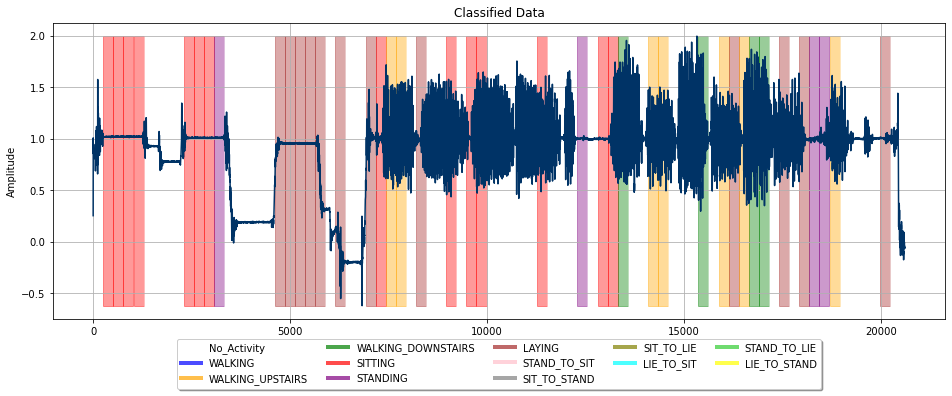

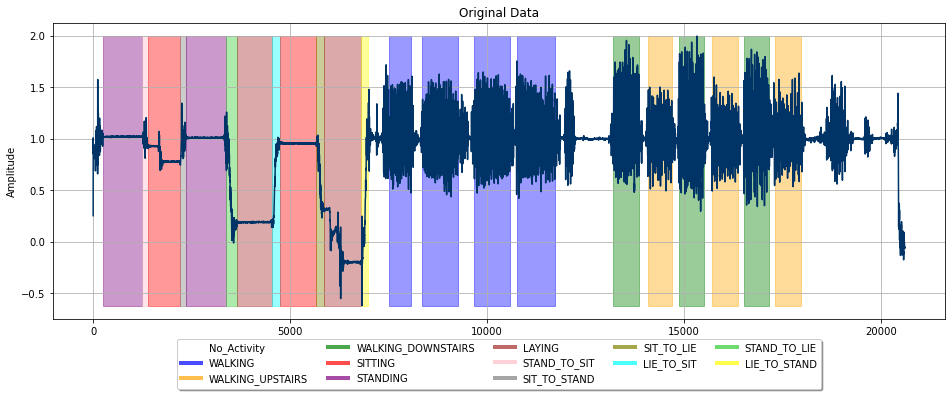

In [372]:
plot_activity(labeled_df,labeled_agg_df, experiment_n = 1)

In [373]:
labels

array([0, 4, 4, 4, 4, 0, 0, 0, 0, 4, 4, 4, 5, 0, 0, 0, 0, 0, 6, 6, 6, 6,
       6, 0, 6, 0, 0, 6, 4, 2, 2, 0, 6, 0, 0, 4, 0, 4, 4, 0, 0, 0, 0, 0,
       4, 0, 0, 0, 5, 0, 4, 4, 3, 0, 0, 2, 2, 0, 0, 0, 3, 0, 2, 6, 2, 3,
       3, 0, 6, 0, 6, 5, 5, 2, 0, 0, 0, 0, 6, 0, 0], dtype=int64)